# Dynamics, Networks and Computation - Homework Exercise #4

**Gal Cesana  --  318510633**

## 2 Cellular Automata and Traffic Flow

### 2.1 Average Speed in Rule 184

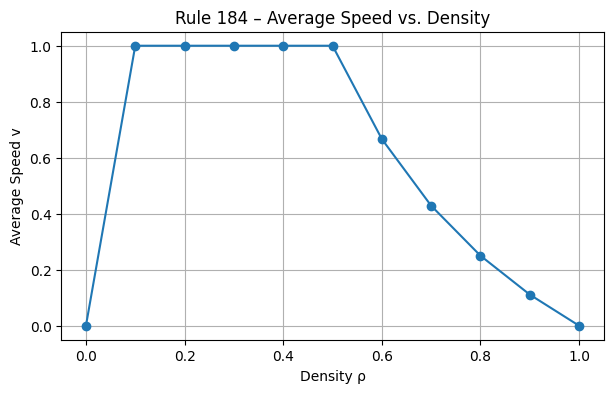

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- PARAMETERS ---
L = 1000                     # length of the 1D ring
burn_in = 500                # steps to equilibrate before measuring
timesteps = 500              # steps over which we measure speeds/flows
realizations = 20             # number of random initial conditions per density
density_values = np.linspace(0.0, 1.0, 21)  # ρ ∈ {0.0, 0.1, 0.2, ..., 1.0}

np.random.seed(42)  # for reproducibility

# Utility: Initialize a ring of length L with exactly n cars (1s) at random positions
def initialize_grid(L, n):
    grid = np.zeros(L, dtype=int)
    if n > 0:
        pos = np.random.choice(L, size=n, replace=False)
        grid[pos] = 1
    return grid

# -----------------------------------------
# 2.1 Rule 184 → “Each car moves right if next cell is empty”
# -----------------------------------------
def update_rule184(grid):
    """
    Standard Rule 184 update on a 1D grid with periodic boundary conditions.
    Returns (new_grid, moved_count).
    """
    L = grid.size
    new = np.zeros_like(grid)
    moved = 0
    for i in range(L):
        if grid[i] == 1:
            nxt = (i + 1) % L
            if grid[nxt] == 0:
                new[nxt] = 1
                moved += 1
            else:
                new[i] = 1
    return new, moved

def simulate_rule184(rho):
    """
    For density ρ, run several realizations of Rule 184 on a ring of length L.
    After burn_in steps, measure how many total car‐moves occur over 'timesteps' steps,
    and compute v = (total moves) / (timesteps * n_cars).
    If n_cars = 0, returns v = 0 to avoid division by zero.
    """
    n_cars = int(rho * L)
    if n_cars == 0:
        return 0.0

    speed_list = []
    for _ in range(realizations):
        grid = initialize_grid(L, n_cars)
        # burn-in
        for _ in range(burn_in):
            grid, _ = update_rule184(grid)

        # measure
        moved_total = 0
        for _ in range(timesteps):
            grid, moved = update_rule184(grid)
            moved_total += moved

        speed_list.append(moved_total / (timesteps * n_cars))

    return np.mean(speed_list)

# Compute v(ρ) for Rule 184
average_speeds = [simulate_rule184(rho) for rho in density_values]

plt.figure(figsize=(7, 4))
plt.plot(density_values, average_speeds, marker='o', linestyle='-')
plt.xlabel('Density ρ')
plt.ylabel('Average Speed v')
plt.title('Rule 184 – Average Speed vs. Density')
plt.grid(True)
plt.show()

### 2.2 Different Speeds

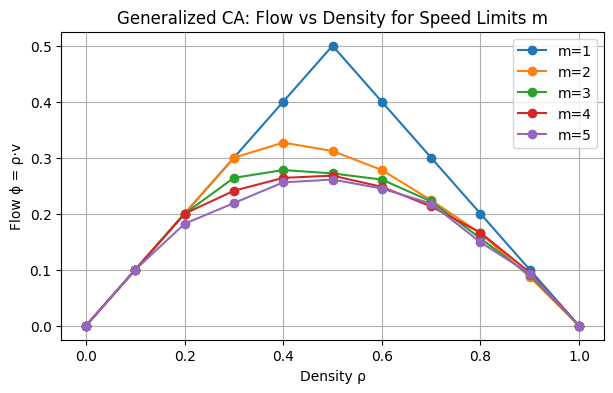

In [4]:
# -----------------------------------------
# 2.2 Generalized Speed Limit m
#   “Each car can move up to m cells to the right, but can’t pass the next car.”
# -----------------------------------------
def update_rule_general(grid, m):
    """
    Generalized rule: a car at i finds the gap to the next car and moves min(m, gap) steps forward.
    Returns (new_grid, moved_count).
    """
    L = grid.size
    new = np.zeros_like(grid)
    moved = 0

    for i in range(L):
        if grid[i] == 1:
            # find gap to the next occupied cell
            gap = 0
            while True:
                nxt = (i + gap + 1) % L
                if grid[nxt] == 0:
                    gap += 1
                else:
                    break
                if gap >= L:
                    break
            move = min(m, gap)
            target = (i + move) % L
            new[target] = 1
            if move > 0:
                moved += 1

    return new, moved

def simulate_general_speed(rho, m):
    """
    For density ρ and speed limit m, run several realizations of the generalized rule.
    After burn_in, measure how many cars move per step (on average), then compute v.
    """
    n_cars = int(rho * L)
    if n_cars == 0:
        return 0.0

    speeds = []
    for _ in range(realizations):
        grid = initialize_grid(L, n_cars)
        for _ in range(burn_in):
            grid, _ = update_rule_general(grid, m)

        moved_total = 0
        for _ in range(timesteps):
            grid, moved = update_rule_general(grid, m)
            moved_total += moved

        speeds.append(moved_total / (timesteps * n_cars))

    return np.mean(speeds)

# Compute ϕ(ρ) = ρ * v(ρ) for m = 1,2,3,4,5
speed_limits = [1, 2, 3, 4, 5]
flow_data = {m: [] for m in speed_limits}

for m in speed_limits:
    for rho in density_values:
        v = simulate_general_speed(rho, m)
        flow_data[m].append(rho * v)

plt.figure(figsize=(7, 4))
for m in speed_limits:
    plt.plot(density_values, flow_data[m], marker='o', label=f'm={m}')
plt.xlabel('Density ρ')
plt.ylabel('Flow ϕ = ρ·v')
plt.title('Generalized CA: Flow vs Density for Speed Limits m')
plt.legend()
plt.grid(True)
plt.show()

- To generalize Rule 184, you simply replace “move at most 1 cell” by "move min(m,g) cells" where g is the number of empty cells before the next car.

- We can see that although car can travel faster in free flow when m < 1, the maximum possible flow actually decreases as m grows, and the peak of the foundamental diagram shifts to lower densities.

### 2.3 Anticipatory Driving

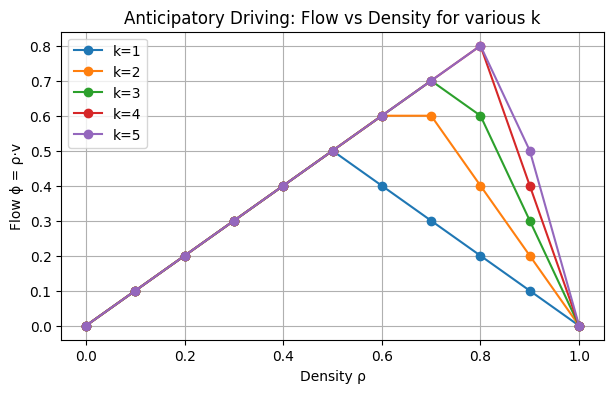

In [5]:
# -----------------------------------------
# 2.3 Anticipatory Driving (m=1, look-ahead k)
#   “Each car looks k cells ahead. If ANY of those k cells is free, it moves 1 step—even if its immediate neighbor is occupied,
#    because it knows that neighbor will move too.”
# -----------------------------------------
def update_anticipatory(grid, k):
    """
    Anticipatory update with look-ahead k. 
    A car checks the next k cells: if ≥1 empty, it moves one step right. Otherwise stays put.
    We temporarily allow multiple “proposed” cars into the same target; then collapse collisions by forcing at most one car per cell.
    Returns (new_grid, moved_count).
    """
    L = grid.size
    new = np.zeros(L, dtype=int)
    moved = 0

    for i in range(L):
        if grid[i] == 1:
            # check next k cells
            can_move = False
            for step in range(1, k + 1):
                nxt = (i + step) % L
                if grid[nxt] == 0:
                    can_move = True
                    break
            if can_move:
                target = (i + 1) % L
                new[target] += 1  # increment to detect collisions
                moved += 1
            else:
                new[i] += 1

    # collapse collisions so that each cell has at most one car
    new[new > 1] = 1
    return new, moved

def simulate_anticipatory(rho, k):
    """
    For density ρ and look-ahead k, run several realizations of the anticipatory rule.
    Returns average speed v and then we’ll multiply by ρ to get ϕ.
    """
    n_cars = int(rho * L)
    if n_cars == 0:
        return 0.0

    speeds = []
    for _ in range(realizations):
        grid = initialize_grid(L, n_cars)
        for _ in range(burn_in):
            grid, _ = update_anticipatory(grid, k)

        moved_total = 0
        for _ in range(timesteps):
            grid, moved = update_anticipatory(grid, k)
            moved_total += moved

        speeds.append(moved_total / (timesteps * n_cars))

    return np.mean(speeds)

# Compute ϕ(ρ) for k = 1,2,3,4,5
anticipation_values = [1, 2, 3, 4, 5]
flow_antic = {k: [] for k in anticipation_values}

for k in anticipation_values:
    for rho in density_values:
        v = simulate_anticipatory(rho, k)
        flow_antic[k].append(rho * v)

plt.figure(figsize=(7, 4))
for k in anticipation_values:
    plt.plot(density_values, flow_antic[k], marker='o', label=f'k={k}')
plt.xlabel('Density ρ')
plt.ylabel('Flow ϕ = ρ·v')
plt.title('Anticipatory Driving: Flow vs Density for various k')
plt.legend()
plt.grid(True)
plt.show()

- **Rule change:**  
  Instead of checking only cell \(i+1\), each car at \(i\) “looks ahead” \(k\) cells (\(i+1,...,i+k\)). If **any** of those \(k\) cells is empty, the car moves one step to \(i+1\). Otherwise it stays. Collisions (multiple cars moving into the same cell) are resolved by keeping only one car per cell.

- **Effect of \(k\):**  
  larger look‐ahead \(k\) lets cars anticipate movement, so jams form at higher densities and maximum throughput increases.








### 2.4 Car Accidents

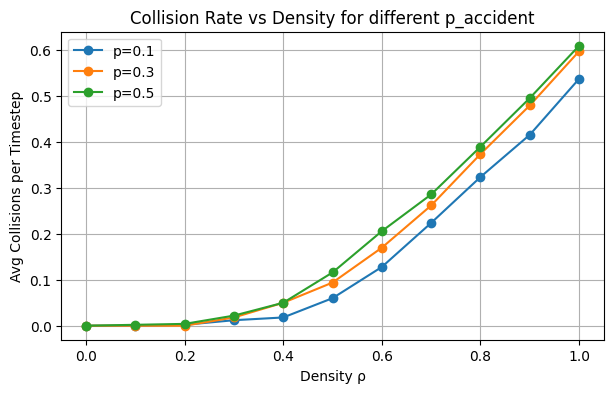

In [ ]:
# -----------------------------------------
# 2.4 Car Accidents
#    “With probability p_accident, a car STILL attempts to move into an occupied cell → collision. 
#     All cars that collide in that cell are removed.”
# -----------------------------------------
def update_with_accidents(grid, p_accident):
    """
    At each step:
    • If the cell ahead is free, the car moves into it.
    • If the cell ahead is occupied, the car STILL tries to move with probability p_accident.
      That produces a collision if multiple cars try to land in the same cell.
    If >1 car land in the same cell, we count that as a collision and remove all colliding cars from that cell.
    Returns (new_grid, moved_count, collisions_count).
    """
    L = grid.size
    proposed = np.zeros(L, dtype=int)    # how many cars want to end up at each cell
    moved_flags = np.zeros(L, dtype=bool)

    for i in range(L):
        if grid[i] == 1:
            nxt = (i + 1) % L
            if grid[nxt] == 0:
                proposed[nxt] += 1
                moved_flags[i] = True
            else:
                # cell ahead is occupied → might “force in” with probability p_accident
                if np.random.rand() < p_accident:
                    proposed[nxt] += 1
                    moved_flags[i] = True
                else:
                    proposed[i] += 1

    new = np.zeros(L, dtype=int)
    collisions = 0
    for pos in range(L):
        if proposed[pos] == 1:
            new[pos] = 1
        elif proposed[pos] > 1:
            # collision: all 'proposed[pos]' cars are gone; count them as collisions
            collisions += proposed[pos]
            # leave the cell empty (new[pos] = 0)

    moved = np.sum(moved_flags)
    return new, moved, collisions

def simulate_accidents(rho, p_accident):
    """
    For density ρ and accident probability p_accident, run realizations.
    We measure “average collisions per timestep” over the measurement window.
    """
    n_cars = int(rho * L)
    if n_cars == 0:
        return 0.0

    collision_list = []
    for _ in range(realizations):
        grid = initialize_grid(L, n_cars)
        total_coll = 0
        for _ in range(timesteps):
            grid, _, coll = update_with_accidents(grid, p_accident)
            total_coll += coll
        collision_list.append(total_coll / timesteps)

    return np.mean(collision_list)

collision_probs = [0.1, 0.3, 0.5]
collision_data = {p: [] for p in collision_probs}

for p in collision_probs:
    for rho in density_values:
        collision_data[p].append(simulate_accidents(rho, p))

plt.figure(figsize=(7, 4))
for p in collision_probs:
    plt.plot(density_values, collision_data[p], marker='o', label=f'p={p}')
plt.xlabel('Density ρ')
plt.ylabel('Avg Collisions per Timestep')
plt.title('Collision Rate vs Density for different p_accident')
plt.legend()
plt.grid(True)
plt.show()

- For small ρ, collisions are almost zero no matter how “reckless” cars are.
- As ρ increases, the collision rate grows rapidly, and higher p leads to noticeably more collisions at every density above the threshold.
- When ρ->1, almost every car is blocked each step, so the collision‐rate curve saturates around p_accident itself.

## 3 Reaction Diffusion and the Gray-Scott System

### 3.2 Gray-Scott Simulation

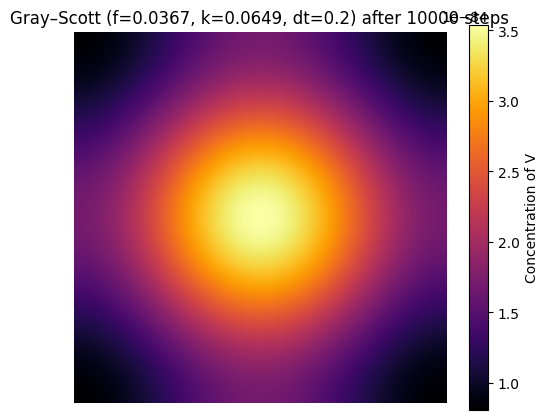

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------------
# PARAMETERS
# ----------------------------------------------------------------------------
Du    = 1.0       # diffusion rate for U
Dv    = 0.5       # diffusion rate for V
f     = 0.0367    # feed rate
k     = 0.0649    # kill rate
dt    = 0.2       # time step (smaller for stability)
steps = 10000     # total number of iterations
N     = 150       # grid size (150×150)

# ----------------------------------------------------------------------------
# 1) LAPLACIAN with periodic boundaries
# ----------------------------------------------------------------------------
def laplacian(Z):
    """
    Compute the 5-point Laplacian of array Z on a torus (periodic edges).
    """
    return (
        np.roll(Z,  1, axis=0) +
        np.roll(Z, -1, axis=0) +
        np.roll(Z,  1, axis=1) +
        np.roll(Z, -1, axis=1) -
        4.0 * Z
    )

# ----------------------------------------------------------------------------
# 2) INITIAL CONDITIONS: 
#    u = 1, v = 0 everywhere except a 20×20 patch in the center where
#    u = 0, v = 1
# ----------------------------------------------------------------------------
u = np.ones((N, N))
v = np.zeros((N, N))

patch = 10
center = N // 2
u[center-patch:center+patch, center-patch:center+patch] = 0.0
v[center-patch:center+patch, center-patch:center+patch] = 1.0

# ----------------------------------------------------------------------------
# 3) TIME-STEPPING LOOP
# ----------------------------------------------------------------------------
for i in range(steps):
    Lu = laplacian(u)
    Lv = laplacian(v)
    uvv = u * (v * v)
    
    # Update u, v with Euler step
    u += (Du * Lu - uvv + f * (1.0 - u)) * dt
    v += (Dv * Lv + uvv - (f + k) * v) * dt
    
    # Clip u and v to [0,1] to avoid blow-up/NaNs
    u = np.clip(u, 0.0, 1.0)
    v = np.clip(v, 0.0, 1.0)

# ----------------------------------------------------------------------------
# 4) PLOT the concentration of v
# ----------------------------------------------------------------------------
plt.figure(figsize=(6, 5))
plt.imshow(v, cmap='inferno', interpolation='bilinear')
plt.colorbar(label='Concentration of V')
plt.title(f'Gray–Scott (f={f}, k={k}, dt={dt}) after {steps} steps')
plt.axis('off')
plt.show()


The Gray–Scott system demonstrates how a very simple “react + diffuse” mechanism gives rise to complicated, patterns in space. 
By balancing reaction rates (feed/kill) against diffusion speeds, you see the arrest of runaway reaction and the emergence of a stable mosaic of spots or stripes.

### 3.3 Extended Gray-Scott

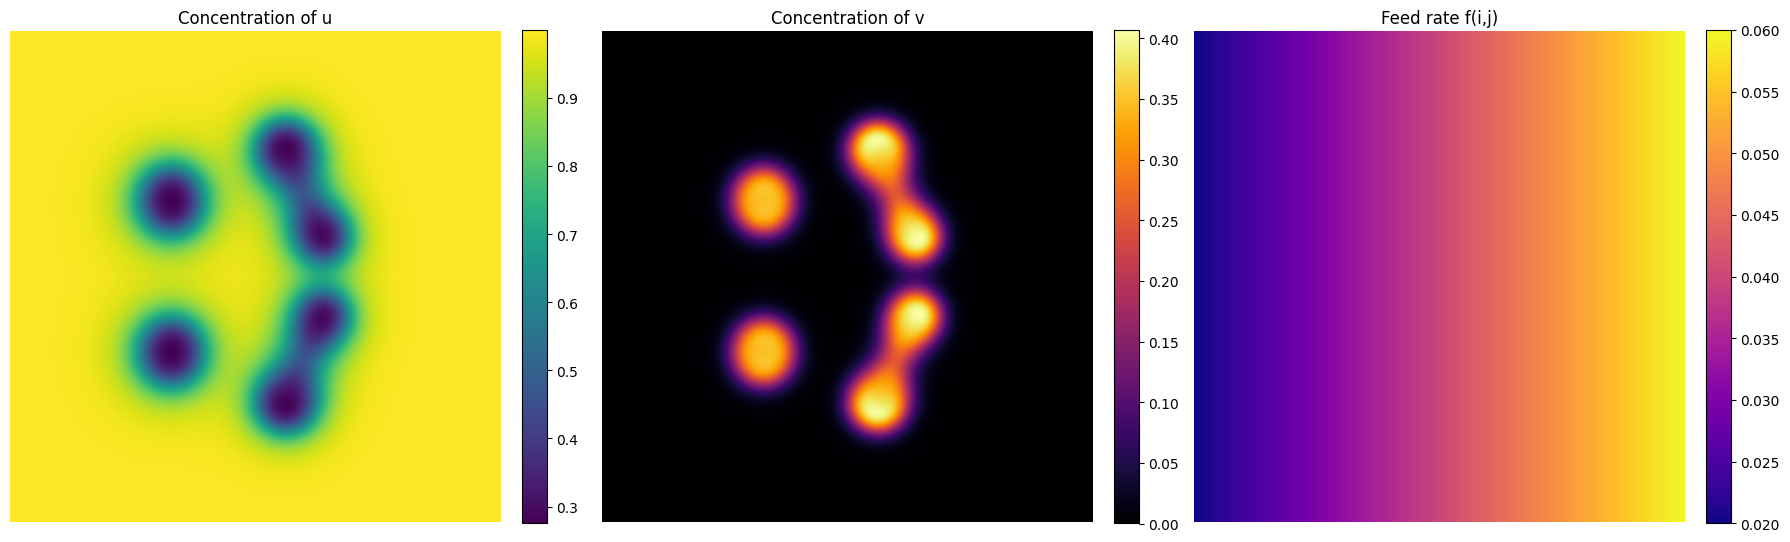

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------------
# EXTENDED GRAY-SCOTT: spatially varying feed rate f(x,y)
# ----------------------------------------------------------------------------

Du = 1.0           # diffusion rate for U
Dv = 0.5           # diffusion rate for V
k = 0.0649         # kill rate
dt = 0.2           # time step
steps = 10000      # number of iterations
N = 150            # grid size

# Build a horizontal gradient of f from 0.02 (left) to 0.06 (right)
f_min, f_max = 0.02, 0.06
f_values = np.linspace(f_min, f_max, N)
f_grid = np.tile(f_values, (N, 1))  # each column j uses f_values[j]

def laplacian(Z):
    return (
        np.roll(Z,  1, axis=0) +
        np.roll(Z, -1, axis=0) +
        np.roll(Z,  1, axis=1) +
        np.roll(Z, -1, axis=1) -
        4.0 * Z
    )

# Initial conditions: u=1, v=0 except central 20×20 patch where u=0, v=1
u = np.ones((N, N))
v = np.zeros((N, N))
patch = 10
center = N // 2
u[center-patch:center+patch, center-patch:center+patch] = 0.0
v[center-patch:center+patch, center-patch:center+patch] = 1.0

# Time‐stepping loop with element‐wise feed rate
for _ in range(steps):
    Lu = laplacian(u)
    Lv = laplacian(v)
    uvv = u * (v * v)
    
    # crucial: use f_grid in place of constant f
    u += (Du * Lu - uvv + f_grid * (1.0 - u)) * dt
    v += (Dv * Lv + uvv - (f_grid + k) * v) * dt
    
    # Clip to [0,1] to prevent runaway values
    u = np.clip(u, 0.0, 1.0)
    v = np.clip(v, 0.0, 1.0)

# Plot u(x,y), v(x,y), and the feed‐field f(x,y)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

im0 = axes[0].imshow(u, cmap='viridis', interpolation='bilinear')
axes[0].set_title('Concentration of u')
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(v, cmap='inferno', interpolation='bilinear')
axes[1].set_title('Concentration of v')
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(f_grid, cmap='plasma', interpolation='nearest')
axes[2].set_title('Feed rate f(i,j)')
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


- Modification chosen: We let the feed parameter f vary across the grid (from 0.02 to 0.06 horizontally).
- Expected change: Lower f regions should show isolated, circular v‐spots. 
- Higher f regions should show elongated stripes or labyrinth patterns. We also expected a smooth transition in between.

- Actual outcome: Exactly that. On the left half, you see clean round v-blobs. Near the middle, those blobs stretch into ovals. On the far right, you see several short, wavy v-stripes/filaments instead of isolated circles.

Hence, our expectation was confirmed: spatially varying the feed rate produces a gradual progression from spot‐type patterns to stripe‐type patterns across the domain—demonstrating how local changes in reaction parameters can yield markedly different morphologies in different subregions.